# 3. ANÁLISIS PREDICTIVO.

## 3.2 ¿Cuál es la mejor hora del día para ir al aeropuerto?

## 3.3 Diseña un modelo que, dada una hora, unas coordenadas origen, y unas coordenadas destino, predice la duración del trayecto y su coste. Muestra la relevancia de los atributos del dataset.

**1. Importar librerías**

In [0]:
import pandas as pd
import numpy as np

**2. Configuración para trabajar en el entorno de collaboratory**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 2.9MB/s 


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import files

In [0]:
csv_import = drive.CreateFile({'id':'1qY1cajRH-FnCEl_I7mVjdhQl9kvBD6Qv'})

In [0]:
 csv_import.GetContentFile('green_tripdata_2015-03.csv') 

**3. Leer datos**

In [0]:
dg3 = pd.read_csv('green_tripdata_2015-03.csv', usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], nrows = 1000000)

**4. Visualización de los datos y shape de los mismos**

In [0]:
dg3.shape

(1000000, 21)

In [0]:
dg3.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,1,2015-03-01 00:02:05,2015-03-01 00:08:01,N,1,-73.961479,40.801872,-73.980721,40.775055,1,2.10,8.0,0.5,0.5,0.0,0.0,NaN,0.3,9.3,1,1
1,1,2015-03-01 00:02:11,2015-03-01 00:27:09,N,1,-73.979759,40.677467,-74.017097,40.710930,1,4.70,20.0,0.5,0.5,4.0,0.0,NaN,0.3,25.3,1,1
2,2,2015-03-01 00:02:07,2015-03-01 00:10:31,N,1,-73.941376,40.833633,-73.926689,40.863411,1,3.09,11.0,0.5,0.5,0.0,0.0,NaN,0.3,12.3,2,1
3,1,2015-03-01 00:02:13,2015-03-01 00:09:09,N,1,-73.939674,40.821152,-73.931854,40.846458,1,2.20,8.5,0.5,0.5,0.0,0.0,NaN,0.3,9.8,4,1
4,2,2015-03-01 00:02:18,2015-03-01 00:07:52,N,1,-73.957344,40.712959,-73.954796,40.719650,6,0.75,5.5,0.5,0.5,1.0,0.0,NaN,0.3,7.8,1,1


**5. Limpieza de datos**

In [0]:
dg3 = dg3.drop("Ehail_fee",1)

In [0]:
dg3 = dg3.drop(dg3[dg3['Total_amount']<=0].index)
dg3 = dg3.drop(dg3[dg3['Total_amount']<=1].index)
dg3 = dg3.drop(dg3[dg3['Total_amount']>=1000].index)

In [0]:
dg3 = dg3.drop(dg3[dg3['Pickup_latitude']<40.49].index)
dg3 = dg3.drop(dg3[dg3['Pickup_latitude']>40.92].index)
dg3 = dg3.drop(dg3[dg3['Pickup_longitude']<-74.27].index)
dg3 = dg3.drop(dg3[dg3['Pickup_longitude']>-73.68].index)
dg3 = dg3.drop(dg3[dg3['Dropoff_latitude']<40.49].index)
dg3 = dg3.drop(dg3[dg3['Dropoff_latitude']>40.92].index)
dg3 = dg3.drop(dg3[dg3['Dropoff_longitude']<-74.27].index)
dg3 = dg3.drop(dg3[dg3['Dropoff_longitude']>-73.68].index)
dg3 = dg3.drop(dg3[dg3['Trip_distance']<0.1].index)


**6. Importar librerías para cambiar formato de fechas**

In [0]:
from datetime import datetime,date
import time

**7. Crear dos nuevas variables, duraciñon del trayecto en segundos y minutos**

In [0]:
dg3['Time_carreer_seconds'] = dg3.apply(
    lambda s:
    time.mktime((datetime.strptime(s['Lpep_dropoff_datetime'],"%Y-%m-%d %H:%M:%S")).timetuple())
    -time.mktime((datetime.strptime(s['lpep_pickup_datetime'],"%Y-%m-%d %H:%M:%S")).timetuple())
    ,axis=1)

In [0]:
dg3['Duración_del_trayecto_min'] = dg3.apply(
    lambda s:
    (s['Time_carreer_seconds'] % 3600) // 60
    ,axis=1)

**8. A  partir de las columnas de fechas, creamos variables que creemos que aportarán valor a nuestro modelo**

In [0]:
def add_datetime_features(dg3):
    
    year = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year
    dg3['year'] = dg3['lpep_pickup_datetime'].map(year)
    print('1/7')
    
    hour = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).hour
    dg3['hour'] = dg3['lpep_pickup_datetime'].map(hour)
    print('2/7')

    day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).weekday()
    dg3['day_of_week'] = dg3['lpep_pickup_datetime'].map(day_of_week)
    print('3/7')

    month = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month
    dg3['month'] = dg3['lpep_pickup_datetime'].map(month)
    print('4/7')

    week_number = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).strftime('%V')
    dg3['week_number'] = dg3['lpep_pickup_datetime'].map(week_number)
    print('5/7')
    
    seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month-1)]
    dg3['season'] = dg3['lpep_pickup_datetime'].map(season)
    print('6/7')
    
    late_night_hours = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
    late_night = lambda x: late_night_hours[(datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).hour)]
    dg3['late_night'] = dg3['lpep_pickup_datetime'].map(late_night)
    print('7/7. All done!')
    
add_datetime_features(dg3)

1/7
2/7
3/7
4/7
5/7
6/7
7/7. All done!


In [0]:
dg3['Duración_del_trayecto_hora'] = dg3.apply(
    lambda s:
    (s['Duración_del_trayecto_min']) // 60
    ,axis=1)

In [0]:
dg3['velocidad'] = (dg3['Trip_distance']/dg3['Duración_del_trayecto_min'])*60

In [0]:
dg3.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type,Time_carreer_seconds,Duración_del_trayecto_min,year,hour,day_of_week,month,week_number,season,late_night,Duración_del_trayecto_hora,velocidad
0,1,2015-03-01 00:02:05,2015-03-01 00:08:01,N,1,-73.961479,40.801872,-73.980721,40.775055,1,2.10,8.0,0.5,0.5,0.0,0.0,0.3,9.3,1,1,356.0,5.0,2015,0,6,3,09,1,1,0.0,25.200
1,1,2015-03-01 00:02:11,2015-03-01 00:27:09,N,1,-73.979759,40.677467,-74.017097,40.710930,1,4.70,20.0,0.5,0.5,4.0,0.0,0.3,25.3,1,1,1498.0,24.0,2015,0,6,3,09,1,1,0.0,11.750
2,2,2015-03-01 00:02:07,2015-03-01 00:10:31,N,1,-73.941376,40.833633,-73.926689,40.863411,1,3.09,11.0,0.5,0.5,0.0,0.0,0.3,12.3,2,1,504.0,8.0,2015,0,6,3,09,1,1,0.0,23.175
3,1,2015-03-01 00:02:13,2015-03-01 00:09:09,N,1,-73.939674,40.821152,-73.931854,40.846458,1,2.20,8.5,0.5,0.5,0.0,0.0,0.3,9.8,4,1,416.0,6.0,2015,0,6,3,09,1,1,0.0,22.000
4,2,2015-03-01 00:02:18,2015-03-01 00:07:52,N,1,-73.957344,40.712959,-73.954796,40.719650,6,0.75,5.5,0.5,0.5,1.0,0.0,0.3,7.8,1,1,334.0,5.0,2015,0,6,3,09,1,1,0.0,9.000


**9. Importamos las librerías para aplicar técnicas de machine learning**

In [0]:
from  sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
import xgboost as xgb



**10. Creamos la distancia esférica para el posterior cálculo del punto 11.**

In [0]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
   
    R_earth = 6371
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

**11. Cálculo de las distancias a los aeropuertos**

In [0]:
def add_airport_dist(dataset):
    """
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = dataset['Pickup_latitude']
    dropoff_lat = dataset['Dropoff_latitude']
    pickup_lon = dataset['Pickup_longitude']
    dropoff_lon = dataset['Dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    dataset['JFKDist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    dataset['EWRDist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    dataset['LGADist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    
    return dataset

**12. Añadimos el dataset creado al dataset existente**

In [0]:
dg3 = add_airport_dist(dg3)

**13. Visualización de los datos**

In [0]:
dg3.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,year,hour,day_of_week,month,week_number,season,late_night,JFKDist,EWRDist,LGADist
0,1,2015-03-01 00:02:05,2015-03-01 00:08:01,N,1,-73.961479,40.801872,-73.980721,40.775055,1,...,2015,0,6,3,09,1,1,22.713038,18.300146,7.966792
1,1,2015-03-01 00:02:11,2015-03-01 00:27:09,N,1,-73.979759,40.677467,-74.017097,40.710930,1,...,2015,0,6,3,09,1,1,17.456094,12.935724,14.231870
2,2,2015-03-01 00:02:07,2015-03-01 00:10:31,N,1,-73.941376,40.833633,-73.926689,40.863411,1,...,2015,0,6,3,09,1,1,25.540934,24.749552,8.532588
3,1,2015-03-01 00:02:13,2015-03-01 00:09:09,N,1,-73.939674,40.821152,-73.931854,40.846458,1,...,2015,0,6,3,09,1,1,24.301112,24.009999,7.463057
4,2,2015-03-01 00:02:18,2015-03-01 00:07:52,N,1,-73.957344,40.712959,-73.954796,40.719650,6,...,2015,0,6,3,09,1,1,17.111327,17.953931,9.431441


In [0]:
dg3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974375 entries, 0 to 999999
Data columns (total 29 columns):
VendorID                     974375 non-null int64
lpep_pickup_datetime         974375 non-null object
Lpep_dropoff_datetime        974375 non-null object
Store_and_fwd_flag           974375 non-null object
RateCodeID                   974375 non-null int64
Pickup_longitude             974375 non-null float64
Pickup_latitude              974375 non-null float64
Dropoff_longitude            974375 non-null float64
Dropoff_latitude             974375 non-null float64
Passenger_count              974375 non-null int64
Trip_distance                974375 non-null float64
Fare_amount                  974375 non-null float64
Extra                        974375 non-null float64
MTA_tax                      974375 non-null float64
Tip_amount                   974375 non-null float64
Tolls_amount                 974375 non-null float64
improvement_surcharge        974375 non-null float

**14. Definimos X e y**

In [0]:
y = dg3['Total_amount']

In [0]:
X = dg3[['Trip_distance',
           'day_of_week','month','year',
           'hour','Passenger_count','Pickup_longitude',
          'Pickup_latitude','Dropoff_longitude','Dropoff_latitude','JFKDist','EWRDist','LGADist', 'Duración_del_trayecto_min']]

**15. Split de las muestras en train y test**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = .3)

**16. Librería para la regresión lineal**

In [0]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

**17. Resultado del algoritmo de la regresión lineal, cuanto más cerca del 0; mejor es el resultado**

In [0]:
lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))



0.7695336340906328
0.7795767416398377


**18. Le aplicamos la métrica del error cuadrático medio, da un valor claramente mejorable**

In [0]:
y_pred = lm.predict(X_test)
lrmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
lrmse



5.107531904509457

**19. Librería para plicar el algoritmo correspondiente al random forest. Una vez importado aplicamos dicho algoritmo sobre el set de datos train**

In [0]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(random_state=42)
randomForest.fit(X_train, y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

**20. Resultado del random forest según la métrica MSE (mean squared error)**

In [0]:
randomForestPredict = randomForest.predict(X_test)
randomForest_mse = mean_squared_error(y_test, randomForestPredict)
randomForestMSE = np.sqrt(randomForest_mse)
randomForestMSE

4.743906549549304

**21. En este apartado tratamos de mejorar el resultado tuneando el algoritmo**

In [0]:
model = RandomForestRegressor(n_estimators=25, max_features=6, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)

**22. Fit del modelo mejorado**

In [0]:
randomForestImproved = model.fit(X_train,y_train)

**23. Resultado del algoritmo mejorado, mejora en 0.2 puntos aproximadamente**

In [0]:
randomForestImprovedPredict = randomForestImproved.predict(X_test)
randomForestImproved_mse = mean_squared_error(y_test, randomForestImprovedPredict)
randomForestImprovedMSE = np.sqrt(randomForestImproved_mse)
randomForestImprovedMSE

4.525558324079368

**24. Importación de librerías para mostrar gráficos relevantes**

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
from plotly.graph_objs import Scatter, Figure, Layout
cf.set_config_file(offline=True)

# Configuración de los gráficos
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

**25. Importancia de las variables para el modelo random forest mejorado**

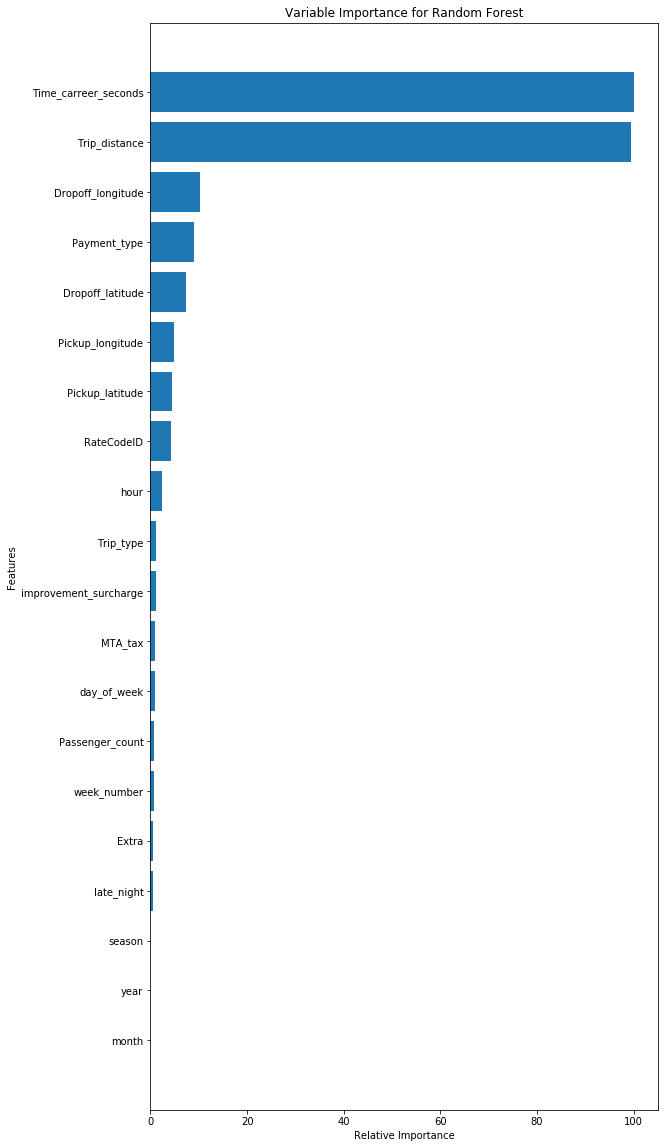

In [0]:
feature_importance = randomForestImproved.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest')
plt.show()



**26. Importamos librería para plicar el algoritmo XGB**

In [0]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

**27. Aplicación algoritmo XGB sobre set de datos train y posterior print del resultado (1.47)**

In [0]:
model = XGBRegressor(learning_rate= .03, colsample_bytree = .8,
                    max_depth= 8, subsample= 1,
                    objective='reg:linear', eval_metric= 'rmse',
                    early_stopping_rounds=10)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

MAE = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error of Model: {}".format(MAE))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean Absolute Error of Model: 1.4722263791660115


**28. Importancia de las variables para el algortimo XGB**

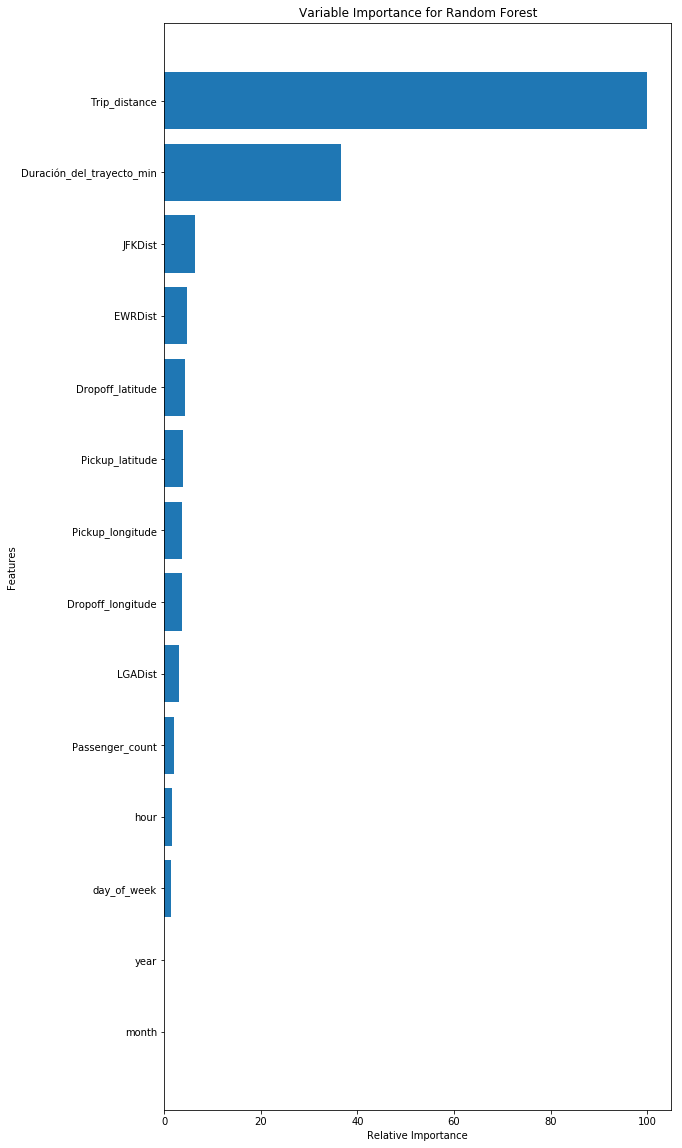

In [0]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest')
plt.show()

**29. Importación de la librería para aplicar el agoritmo Gradient boost**

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
model_gradient= GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=3, random_state=0)
gradientBoost = model_gradient.fit(X_train, y_train)

In [0]:
predicted = model_gradient.predict(X_test)

**30. Resultado algoritmo Gradient Boost**

In [0]:
grmse = np.sqrt(metrics.mean_squared_error(predicted, y_test))
grmse

4.921257018702692

**31. Importancia de las variables para el algortimo Gradient Boost**

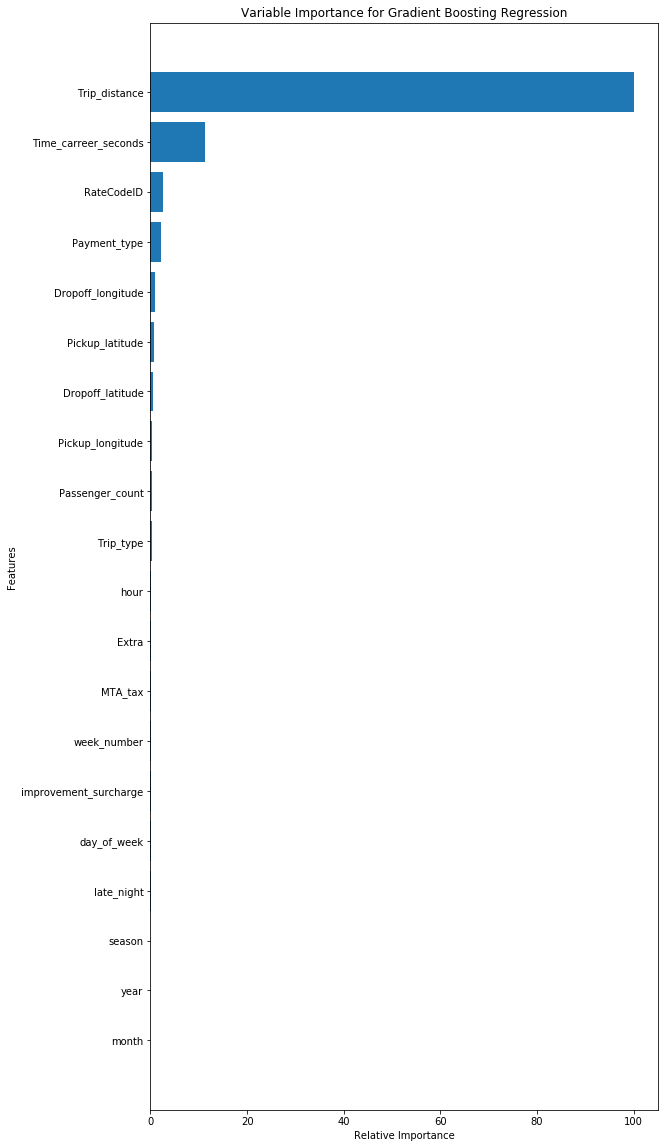

In [0]:
feature_importance = gradientBoost.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Gradient Boosting Regression')
plt.show()

**32. Creación gráfico para mostrar el rendimiento de los diferentes algoritmos frente al set de datos**

In [0]:
regression = pd.DataFrame({"regression": ['Multi Linear Regression','Random Forest', 'Improved Random Forest', 'Gradient Boosting Regression', 'XGBRegressor'], "rmse": [lrmse,randomForestMSE,randomForestImprovedMSE,grmse,MAE]},columns = ['regression','rmse'])

In [0]:
regression = regression.sort_values(by='rmse', ascending = False)

**33. El algoritmo XGB es el que muestra un mejor comportamiento a la hora de predecir**

Text(0.5, 1.0, 'Comparación de los diferentes algoritmos utilizados')

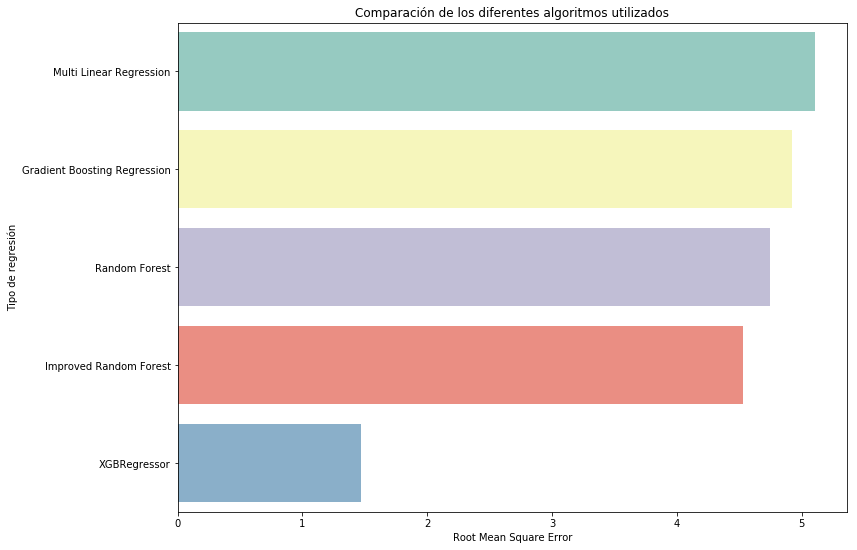

In [0]:
sns.barplot(regression['rmse'], regression['regression'], palette = 'Set3')
plt.xlabel("Root Mean Square Error")
plt.ylabel('Tipo de regresión')
plt.title('Comparación de los diferentes algoritmos utilizados')